# Notes on the statFEM posterior: Langevin samplers
*Connor Duffin*

In this notebook we study the Langevin samplers in the context of the statFEM posterior problem, where we are trying to estimate $p(u | y) = \int p(u | y, \theta) p(\theta) d \theta$. We use the same model specification as in the prior, that is: $p(\theta) = \log \mathcal{GP}(m_\theta, k_\theta)$ and $p(u | \theta) = \mathcal{N}(A_\theta^{-1}b, A_\theta^{-1} G A_\theta^{-\top})$

We also assume that data generating process $y_i = Hu + \eta$, $\eta \sim \mathcal{N}(0, \sigma^2I)$, for a single observation vector $y_i \in \mathbb{R}^{n_y}$. We assume that, in total, $n_{\mathrm{obs}}$ observation vectors were taken, so that the total dataset $y \in \mathbb{R}^{n_y \times n_{\mathrm{obs}}}$.

The conditional posterior distribution $p(u | y, \theta)$ is given by

\begin{gather*}
  p(u | \theta, y) = \mathcal{N}(m_{u, \theta}, C_{u, \theta}), \\
  m_{u, \theta} = C_{u, \theta} \left(
    A_\theta^\top G A_\theta u
    + \sum_{i = 1}^{n_\text{obs}} H^\top R^{-1} y_i
  \right), \\
C_{u, \theta}^{-1} = A_\theta^\top G A_\theta + n_\text{obs} H^\top R^{-1} H.
\end{gather*}

An important observation is that the precision $C_{u, \theta}^{-1}$ is sparse, which can be made use of for efficient computation (e.g. to draw samples from the exact posterior distribution, or, to construct efficient preconditioners).

In this notebook we compare the performance of various Langevin-based sampelrs in order to sample from $p(u | y)$. The  samplers we compare are:

1. MALA and pMALA
2. ULA and pULA
3. Preconditioned-Crank-Nicolson.

The Langevin preconditioners use the full-rank mean-$\theta$ Hessian as the preconditioner, i.e. $M^{-1} = A_{\bar \theta}^\top G A_{\bar \theta} + n_\text{obs} H^\top R^{-1} H$, which is computed and applied using the sparse Cholesky factorization, as implemented in [CHOLMOD](https://scikit-sparse.readthedocs.io/en/latest/cholmod.html), which is a very nice, well-documented library. PCN uses the prior covariance to construct proposals that are reversible with respect to the prior. This gives the likelihood ratio as the acceptance probability, which is cheaper to evaluate than the full posterior. It is also robust under mesh-refinement.

Note: we use a low-dimensional $32 \times32$ mesh in this example for illustration. If you have access to machine with lots of memory and a good processor, then this notebook should be able to be run up to $\approx 1024 \times 1024$ mesh dimensions.

Let's start with loading some libraries:

In [1]:
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

from pyDOE import lhs
from sfmcmc.samplers import PoissonUnitThetaPosterior

np.random.seed(27)

And setting up the statFEM class, instatiating the class and sampling from $p(\theta)$ using the Kronecker structure:

In [2]:
pois = PoissonUnitThetaPosterior(32)
pois.setup_G(sigma=0.05)
pois.setup_theta(0.2, 0.2, method="kronecker")

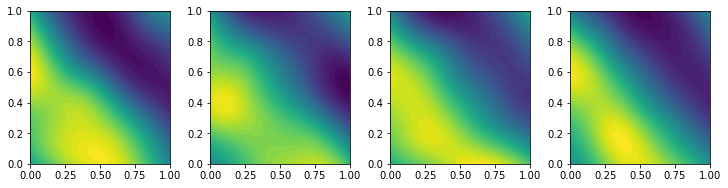

In [3]:
n_theta_samples = 4
fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), constrained_layout=True)
for i in range(n_theta_samples):
    pois.sample_theta()
    ax[i].tricontourf(pois.x_dofs[:, 0], pois.x_dofs[:, 1], pois.theta.vector(), 64)

And let's now setup the data-generating-process (DGP). To do so, we specify that we want $n_{\mathrm{obs}} = 100$ observations, at $64$ locations, with noise $10^{-3}$. Data are generating from solving the stochastic Poisson, and scaling up by a scale factor of $1.4$, in order to induce some model mismatch.

In [5]:
x_obs = lhs(2, 64)
pois.setup_dgp(x_obs, n_obs=100, sigma=1e-3, scale_factor=1.4)
pois.setup_pc_post()
pois.generate_data()
print(pois.y.shape)

(64, 100)


And we now check to see what the data look like:

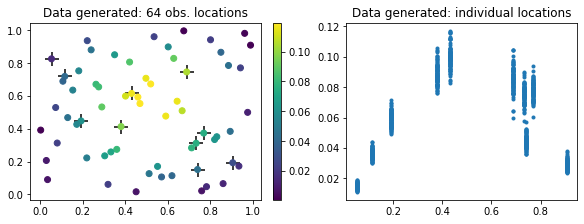

In [6]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs = axs.flatten()
im = axs[0].scatter(x_obs[:10, 0], x_obs[:10, 1], marker="+", c="black", s=200)
im = axs[0].scatter(x_obs[:, 0], x_obs[:, 1], c=pois.y[:, 0])
plt.colorbar(im, ax=axs[0])
axs[0].set_title(f"Data generated: {pois.n_y} obs. locations")

axs[1].set_title(f"Data generated: individual locations")
axs[1].plot(x_obs[:10, 0], pois.y[:10, :], ".", color="tab:blue")
plt.show()

What does a sample from the posterior look like? And how does it compare to a sample from the prior?

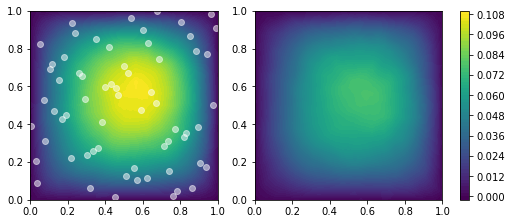

In [7]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7,3))

u_post = pois.sample_posterior_exact()
u_prior = pois.sample_prior_exact()

vmin = u_post.min()
vmax = u_post.max()

im = axs[0].tricontourf(pois.x_dofs[:, 0], pois.x_dofs[:, 1], u_post, 64, vmin=vmin, vmax=vmax)
axs[0].scatter(x_obs[:, 0], x_obs[:, 1], alpha=0.5, color="white")

axs[1].tricontourf(pois.x_dofs[:, 0], pois.x_dofs[:, 1], u_prior, 64, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])
plt.show()

Now, let's check to see what the precision matrix looks like, and how adding in observed data into the mix effects things.

We first compute the precision, and its first 200 eigenvalues, to see what they look like:

In [8]:
C_inv = pois.compute_precision()

def mv(x):
    return pois.factor.solve_A(x)

from scipy.sparse.linalg import eigsh, LinearOperator

C = LinearOperator(shape=C_inv.shape, matvec=mv)

sigma_C = eigsh(C, k=200, return_eigenvectors=False)
print("Approx condition number:", sigma_C[-1] / sigma_C[0])

Approx condition number: 248.75069860859446


Now this is an approximate condition number. Now compared to the prior (approx $100$ times better conditioned):

In [9]:
pois.setup_pc("lu")

def mv(x):
    return pois.M.solve_A(pois.G @ (pois.M.solve_A(x)))

C = LinearOperator(shape=C_inv.shape, matvec=mv)

sigma_prior = eigsh(C, k=200, return_eigenvectors=False)
print("Approximate condition number (prior):", sigma_prior[-1] / sigma_prior[0])

Approximate condition number (prior): 12789.392106492041


And we can see how the spectrum compares between the prior and posterior:

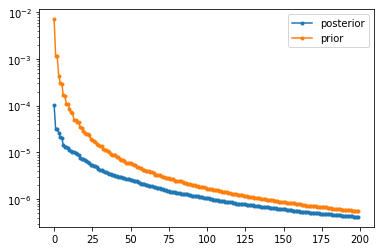

In [10]:
plt.semilogy(sigma_C[::-1], ".-", label="posterior")
plt.semilogy(sigma_prior[::-1], ".-", label="prior")
plt.legend()
plt.show()

And we can see that the inclusion of data reduces the magnitude of the high-variance modes and flattens the spectrum. This makes sense as the inclusion of data should reduce uncertainty of the process at hand (under the assumption that the noise on the data is not too large).

Now we check to see what the sparsity pattern of the precision looks like:

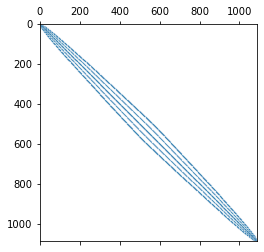

In [11]:
plt.spy(C_inv, marker=".", ms=0.1)
plt.show()

Now taking the Cholesky has resulted in a little bit of fill-in, but not too much (around $4\times$):

Precision NNZ: 12043
Cholesky NNZ: 47337


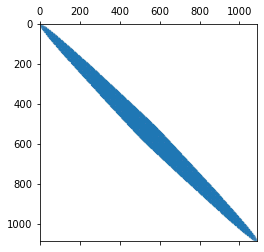

In [13]:
print("Precision NNZ:", C_inv.nnz)
print("Cholesky NNZ:", pois.factor.L().nnz)
plt.spy(pois.factor.L() + pois.factor.L().T, marker=".", ms=0.1)
plt.show()

## Sampler comparisons

We now compare 5 samplers for the above posterior problem:

* ULA
* Preconditioned ULA
* pCN (acceptance rate $\approx 0.25$).
* MALA (acceptance rate $\approx 0.5$).
* Preconditioned MALA (acceptance rate $\approx 0.5$).

For the MCMC algorithms we tune the methods to have approximately "optimal" acceptance rates. We store the evaluations of the log-likelihood $p(y | u_k)$ at each iteration, to check that the samplers converge to the same spot.

In [12]:
def adapt_stepsize(stepsize, lower, upper, scale=0.1):
    if acceptance_ratio >= upper:
        stepsize *= (1 + scale)
    elif acceptance_ratio <= lower:
        stepsize *= (1 - scale)

    return stepsize    

In [15]:
n_sample = 1000
pois.setup_pc_post()
samples_exact = np.zeros((n_sample, pois.n_dofs))
ll_exact = np.zeros((n_sample, ))

for i in range(n_sample):
    u = pois.sample_posterior_exact()
    samples_exact[i, :] = u
    ll_exact[i] = pois.log_likelihood(u)

Now we run ULA and pULA

In [16]:
pois.u = pois.sample_posterior_exact()
samples_ula = np.zeros((n_sample, pois.n_dofs))
ll_ula = np.zeros((n_sample, ))

i_save = 0
n_inner = 10
eta = 1e-8
for i in range(n_inner * n_sample):
    if i % n_inner == 0:
        u = pois.u
        samples_ula[i_save, :] = u
        ll_ula[i_save] = pois.log_likelihood(u)
        i_save += 1
        
        pois.ula_step(eta, fixed_theta=False)
    else:
        pois.ula_step(eta, fixed_theta=True)
    
    if np.any(pois.u > 1e6):
        print(f"ULA failed at iteration {i}")
        break

In [17]:
pois.u = pois.sample_posterior_exact()
samples_pula = np.zeros((n_sample, pois.n_dofs))
ll_pula = np.zeros((n_sample, ))

i_save = 0
n_inner = 10
eta = (32 + 1)**(-2 / 3)
for i in range(n_inner * n_sample):
    if i % n_inner == 0:
        u = pois.u
        samples_pula[i_save, :] = u
        ll_pula[i_save] = pois.log_likelihood(u)
        i_save += 1
        
        pois.pula_step(eta, fixed_theta=False)
    else:
        pois.pula_step(eta, fixed_theta=True)


    if np.any(pois.u > 1e6):
        print(f"ULA failed at iteration {i}")
        break

Now pCN:

In [18]:
pois.u = pois.sample_posterior_exact()
samples_pcn = np.zeros((n_sample, pois.n_dofs))
ll_pcn = np.zeros((n_sample, ))

beta = 1e-2
n_accept = 0
for i in range(n_sample):
    accepted = pois.pcn_step(beta, fixed_theta=False)
    
    for j in range(n_inner - 1):
        accepted = pois.pcn_step(beta, fixed_theta=True)
        
    if accepted: n_accept += 1
        
    if i % 100 == 0:
        acceptance_ratio = n_accept / 100
        print(f"Acceptance ratio: {acceptance_ratio}, beta = {beta:.6e}")
        n_accept = 0
    
    u = pois.u  
    samples_pcn[i, :] = u
    ll_pcn[i] = pois.log_likelihood(u)

Acceptance ratio: 0.0, beta = 1.000000e-02
Acceptance ratio: 0.33, beta = 1.000000e-02
Acceptance ratio: 0.33, beta = 1.000000e-02
Acceptance ratio: 0.29, beta = 1.000000e-02
Acceptance ratio: 0.35, beta = 1.000000e-02
Acceptance ratio: 0.22, beta = 1.000000e-02
Acceptance ratio: 0.26, beta = 1.000000e-02
Acceptance ratio: 0.22, beta = 1.000000e-02
Acceptance ratio: 0.24, beta = 1.000000e-02
Acceptance ratio: 0.24, beta = 1.000000e-02


And MALA and pMALA:

In [19]:
pois.u = pois.sample_posterior_exact()
samples_mala = np.zeros((n_sample, pois.n_dofs))
ll_mala = np.zeros((n_sample, ))

eta = 5e-9
n_accept = 0
for i in range(n_sample):
    accepted = pois.mala_step(eta, fixed_theta=False)

    for j in range(n_inner - 1):
        accepted = pois.mala_step(eta, fixed_theta=True)
    
    if accepted: n_accept += 1
        
    if i % 100 == 0:
        acceptance_ratio = n_accept / 100
        print(f"Acceptance ratio: {acceptance_ratio}, eta = {eta:.6f}")
        n_accept = 0
        
    u = pois.u  
    samples_mala[i, :] = u
    ll_mala[i] = pois.log_likelihood(u)

Acceptance ratio: 0.01, eta = 0.000000
Acceptance ratio: 0.6, eta = 0.000000
Acceptance ratio: 0.69, eta = 0.000000
Acceptance ratio: 0.61, eta = 0.000000
Acceptance ratio: 0.64, eta = 0.000000
Acceptance ratio: 0.61, eta = 0.000000
Acceptance ratio: 0.69, eta = 0.000000
Acceptance ratio: 0.63, eta = 0.000000
Acceptance ratio: 0.68, eta = 0.000000
Acceptance ratio: 0.68, eta = 0.000000


In [20]:
pois.u = pois.sample_posterior_exact()
pois.setup_pc_post()
samples_pmala = np.zeros((n_sample, pois.n_dofs))
ll_pmala = np.zeros((n_sample, ))

eta = 1e-1
n_accept = 0
for i in range(n_sample):
    accepted = pois.pmala_step(eta, fixed_theta=False)
    
    for j in range(n_inner - 1):
        accepted = pois.pmala_step(eta, fixed_theta=True)
    
    if accepted:
        n_accept += 1
                
    if i % 100 == 0:
        acceptance_ratio = n_accept / 100
        print(f"Acceptance ratio: {acceptance_ratio}, eta = {eta:.6f}")
        n_accept = 0
        
    u = pois.u  
    samples_pmala[i, :] = u
    ll_pmala[i] = pois.log_likelihood(u)

Acceptance ratio: 0.01, eta = 0.100000
Acceptance ratio: 0.75, eta = 0.100000
Acceptance ratio: 0.76, eta = 0.100000
Acceptance ratio: 0.75, eta = 0.100000
Acceptance ratio: 0.73, eta = 0.100000
Acceptance ratio: 0.72, eta = 0.100000
Acceptance ratio: 0.68, eta = 0.100000
Acceptance ratio: 0.67, eta = 0.100000
Acceptance ratio: 0.68, eta = 0.100000
Acceptance ratio: 0.75, eta = 0.100000


## Posterior visualizations

First, we plot the traceplots of the log-likelihood:

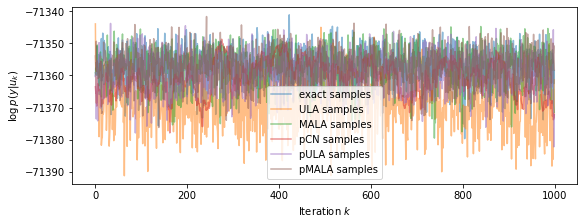

In [21]:
alpha = 0.5
n_start = 0

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 3))
ax.plot(ll_exact[n_start:], alpha=alpha, label="exact samples")
ax.plot(ll_ula[n_start:],  alpha=alpha, label="ULA samples")
ax.plot(ll_mala[n_start:], alpha=alpha, label="MALA samples")
ax.plot(ll_pcn[n_start:], alpha=alpha, label="pCN samples")
ax.plot(ll_pula[n_start:], alpha=alpha, label="pULA samples")
ax.plot(ll_pmala[n_start:], alpha=alpha, label="pMALA samples")
ax.set_ylabel(r"$\log p(y | u_k)$")
ax.set_xlabel(r"Iteration $k$")

plt.legend()
plt.show()

Which gives a nice characterization of the performance of each of the samplers. It seems that the bias of ULA is visually apparent in this example, failing to converge to the same stationary measure as the rest of the samplers. Note also that pCN is very sticky and doesn't mix very well, which we also see in the ACF plots:

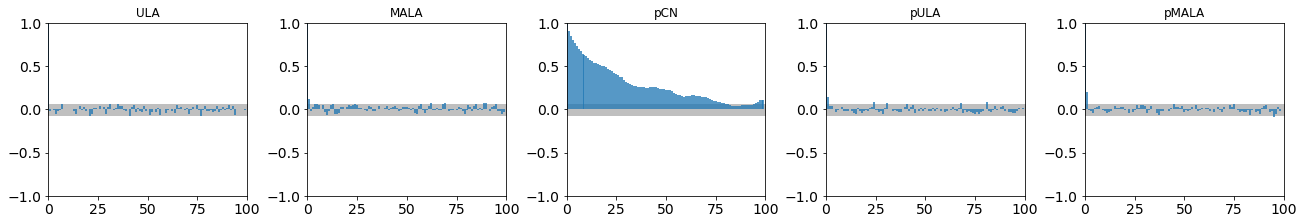

In [20]:
import arviz as az
fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(18, 3))

az.plot_autocorr(ll_ula, ax=axs[0])
axs[0].set_title("ULA")
az.plot_autocorr(ll_mala, ax=axs[1])
axs[1].set_title("MALA")
az.plot_autocorr(ll_pcn, ax=axs[2])
axs[2].set_title("pCN")
az.plot_autocorr(ll_pula, ax=axs[3])
axs[3].set_title("pULA")
az.plot_autocorr(ll_pmala, ax=axs[4])
axs[4].set_title("pMALA")
plt.show()

Next we check the trace plots on the individual FEM coefficients, which seem to reinforce the results on the sampler performance that we got from the previous plots. Note that it also seems as though the ULA bias is not too apparent in this plot. This reinforces the theoretical result that for this case, bias comes in at the variance, and not in the mean.

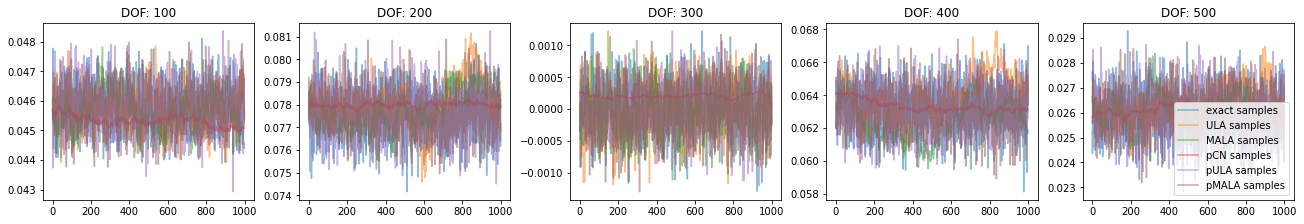

In [22]:
alpha = 0.5
n_start = 0
dofs = [100, 200, 300, 400, 500]
fig, axs = plt.subplots(1, len(dofs), constrained_layout=True, figsize=(18, 3))
for i, dof in enumerate(dofs):
    axs[i].plot(samples_exact[n_start:, dof], alpha=alpha, label="exact samples")
    axs[i].plot(samples_ula[n_start:, dof], alpha=alpha,  label="ULA samples")
    axs[i].plot(samples_mala[n_start:, dof], alpha=alpha, label="MALA samples")
    axs[i].plot(samples_pcn[n_start:, dof], alpha=alpha, label="pCN samples")
    axs[i].plot(samples_pula[n_start:, dof], alpha=alpha, label="pULA samples")
    axs[i].plot(samples_pmala[n_start:, dof], alpha=alpha, label="pMALA samples")
    axs[i].set_title(f"DOF: {dof}")

plt.legend()
plt.show()

Now we also check that the variance estimate, from the mean samples, is not too bad:

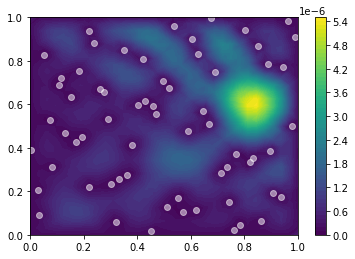

In [23]:
var_exact = np.var(samples_exact, axis=0)
plt.tricontourf(pois.x_dofs[:, 0], pois.x_dofs[:, 1], var_exact, 64)
plt.colorbar()
plt.scatter(x_obs[:, 0], x_obs[:, 1], alpha=0.5, color="white")
plt.show()

And we finally run some checks on the pULA and pMALA samplers, to make sure they are robust to different starting points. This could be done in parallel, using, e.g., the `multiprocessing` module, but (due to laziness) is done here in serial.

In [24]:
def run_pmala(eta):
    pois.u = pois.sample_posterior_exact()
    ll = np.zeros((n_sample, ))

    n_accept = 0
    for i in range(n_sample):
        accepted = pois.pmala_step(eta)
        ll[i] = pois.log_likelihood(pois.u)

    return ll


chains_pmala = []
for i in range(4):
    results = run_pmala(2e-2)
    chains_pmala.append(results)

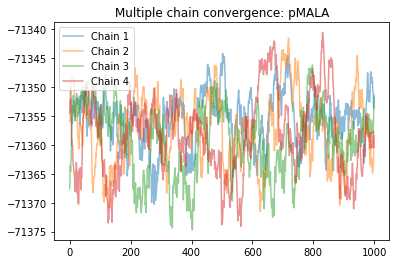

In [25]:
for i, chain in enumerate(chains_pmala):
    plt.plot(chain, alpha=0.5, label=f"Chain {i + 1}")
    
plt.title("Multiple chain convergence: pMALA")
plt.legend()
plt.show()

In [26]:
def run_pula(eta):
    pois.u = pois.sample_posterior_exact()
    ll = np.zeros((n_sample, ))

    n_accept = 0
    n_interval = 100
    for i in range(n_sample):
        pois.pula_step(eta, fixed_theta=True)
        ll[i] = pois.log_likelihood(pois.u)

    return ll

chains_pula = []
for i in range(4):
    results = run_pula(1e-1)
    chains_pula.append(results)

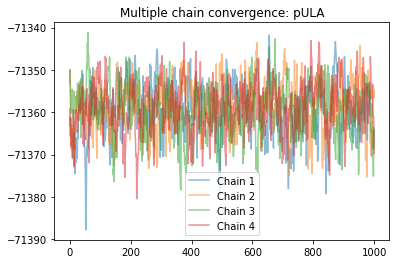

In [27]:
for i, chain in enumerate(chains_pula):
    plt.plot(chain, alpha=0.5, label=f"Chain {i + 1}")

plt.title("Multiple chain convergence: pULA")
plt.legend()
plt.show()